## Visualize Linear Model Power Analysis

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

In [2]:
output_power_figure <- file.path("figures", "power_analysis_all_cp_lm_plate2.png")
output_dp_power_figure <- file.path("figures", "power_analysis_dp_lm.png")

## Visualize CP power analysis

In [3]:
# Load linear modeling results
lm_results_file <- file.path("results", "Plate2", "linear_model_all_cp_features.tsv")
lm_results_df <- readr::read_tsv(
    lm_results_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Load linear modeling power
lm_power_file <- file.path("results", "Plate2", "power_analysis_all_cp_features_lm_plate2.tsv")
lm_power_df <- readr::read_tsv(
    lm_power_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Merge for visualization
lm_data_df <- lm_results_df %>%
    dplyr::left_join(lm_power_df, by = "feature") %>%
    dplyr::arrange(estimated_sample_size) %>%
    dplyr::filter(estimated_sample_size < 100000) %>%  # Remove extreme outliers
    dplyr::filter(!is.na(power))

print(dim(lm_data_df))
head(lm_data_df)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] 1146   10


feature,r2_score,cell_count_coef,Null_coef,WT_coef,u,v,sig_level,power,estimated_sample_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cells_Intensity_MinIntensityEdge_RFP,0.2554262,0.03563833,-0.0464274,0.0464274,1,1679,4.173623e-05,0.8,79.50090
Cytoplasm_Intensity_MinIntensityEdge_RFP,0.2488403,0.03545871,-0.0531494,0.0531494,1,1679,4.173623e-05,0.8,82.02950
Cytoplasm_AreaShape_Area,0.2277815,-0.01307942,-0.3324352,0.3324352,1,1679,4.173623e-05,0.8,91.09568
Cells_AreaShape_Area,0.2263696,-0.01297012,-0.3323415,0.3323415,1,1679,4.173623e-05,0.8,91.76384
Cells_Texture_InfoMeas2_DAPI_3_01_256,0.2197778,0.01123586,0.3481463,-0.3481463,1,1679,4.173623e-05,0.8,94.99688
Cytoplasm_AreaShape_EquivalentDiameter,0.2191631,-0.01305161,-0.3230428,0.3230428,1,1679,4.173623e-05,0.8,95.30826


In [4]:
# Load feature data (for current n)
data_dir <-file.path("..", "..", "..", "4_processing_features", "data", "Plate2", "CellProfiler")
cp_file <- file.path(data_dir, "nf1_sc_norm_cellprofiler_plate2.csv.gz")

cp_df <- readr::read_csv(
    cp_file,
    col_types = readr::cols(
        .default="d",
        Metadata_WellRow="c",
        Metadata_WellCol="c",
        Metadata_Well="c",
        Metadata_gene_name="c",
        Metadata_genotype="c"
    )
)

n_samples <- dim(cp_df)[1]

print(dim(cp_df))
head(cp_df, 3)

New names:
• `` -> `...1`


[1] 1681 1211


...1,Metadata_WellRow,Metadata_WellCol,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,⋯,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,A,1,47,NF1,WT,5,1,A1,1,⋯,-0.4953495,-0.5140452,-0.5556103,-0.5599953,-0.5487354,-0.5557258,-0.3484580,-0.3405557,-0.3503081,-0.3460403
1,A,1,47,NF1,WT,5,1,A1,2,⋯,-0.3640100,-0.3558701,-0.5269353,-0.5195026,-0.5204616,-0.5214104,-0.3260656,-0.3214580,-0.3281426,-0.3220526
2,A,1,47,NF1,WT,5,1,A1,3,⋯,-0.5607370,-0.5620716,-0.5870021,-0.5814423,-0.5864145,-0.5869553,-0.2572193,-0.2587695,-0.2623094,-0.2488917


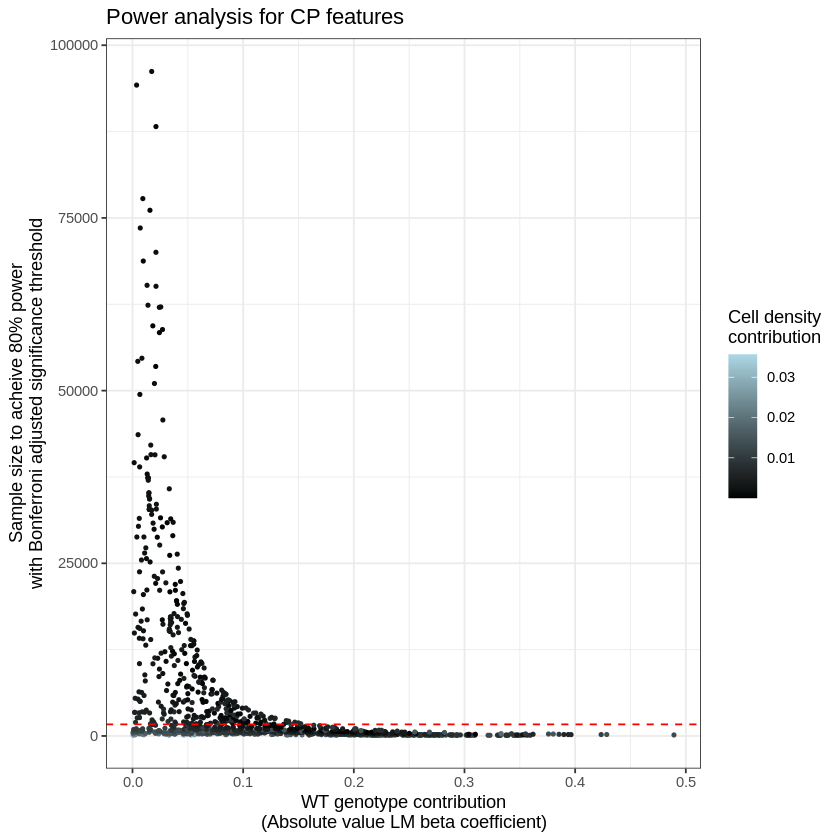

In [5]:
power_gg <- (
    ggplot(lm_data_df, aes(y = estimated_sample_size, x = abs(WT_coef)))
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for CP features")
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_gg

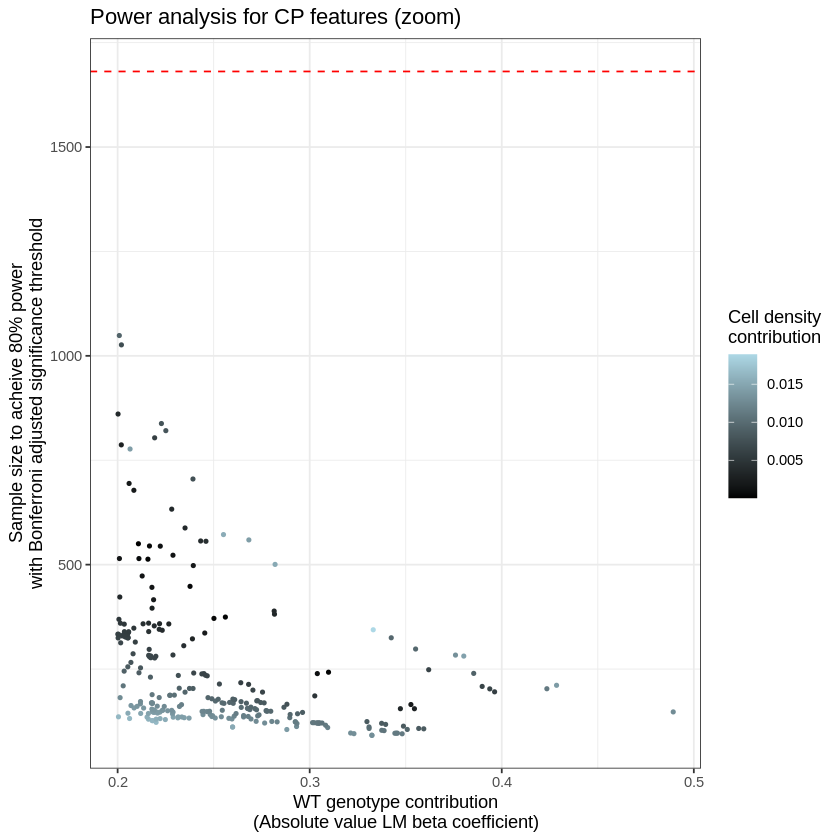

In [6]:
power_zoom_gg <- (
    ggplot(
        lm_data_df %>% dplyr::filter(abs(WT_coef) > 0.2),
        aes(y = estimated_sample_size, x = abs(WT_coef))
    )
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for CP features (zoom)")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_zoom_gg

In [7]:
full_power_gg <- power_gg + power_zoom_gg
ggsave(output_power_figure, full_power_gg, dpi = 500, width = 13, height = 6)

## Visualize DP power analysis

In [8]:
# Load linear modeling results
lm_results_file <- file.path("results", "linear_model_dp_features.tsv")
lm_results_df <- readr::read_tsv(
    lm_results_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Load linear modeling power
lm_power_file <- file.path("results", "power_analysis_dp_cyto_features_lm.tsv")
lm_power_df <- readr::read_tsv(
    lm_power_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Merge for visualization
lm_data_df <- lm_results_df %>%
    dplyr::left_join(lm_power_df, by = "feature") %>%
    dplyr::arrange(estimated_sample_size) %>%
    dplyr::filter(estimated_sample_size < 100000) %>%  # Remove extreme outliers
    dplyr::filter(!is.na(power))

print(dim(lm_data_df))
head(lm_data_df)

[1] 3799   10


feature,r2_score,cell_count_coef,Null_coef,WT_coef,u,v,sig_level,power,estimated_sample_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
efficientnet_303,0.7121824,-0.04768199,0.22838587,-0.22838587,1,254,1.304802e-05,0.8,19.95912
efficientnet_1229,0.6669157,0.04732462,-0.26884737,0.26884737,1,254,1.304802e-05,0.8,22.63003
efficientnet_225,0.6382288,0.04508816,-0.21422096,0.21422096,1,254,1.304802e-05,0.8,24.50150
efficientnet_565,0.6092117,-0.04507551,0.25052375,-0.25052375,1,254,1.304802e-05,0.8,26.56260
efficientnet_1126,0.5833654,0.03993216,-0.08740081,0.08740081,1,254,1.304802e-05,0.8,28.56285
efficientnet_134,0.5831218,-0.04469410,0.26995910,-0.26995910,1,254,1.304802e-05,0.8,28.58251


In [9]:
# Load feature data (for calculating n)
data_dir <-file.path("..", "..", "..", "4_processing_features", "data", "Plate1", "DeepProfiler")
dp_file <- file.path(data_dir, "nf1_sc_norm_deepprofiler_cyto.csv.gz")

dp_df <- readr::read_csv(
    dp_file,
    col_types = readr::cols(
        .default="d",
        Metadata_Plate="c",
        Metadata_Well="c",
        Metadata_Site="c",
        Metadata_Plate_Map_Name="c",
        Metadata_DNA="c",
        Metadata_ER="c",
        Metadata_Actin="c",
        Metadata_Genotype="c",
        Metadata_Genotype_Replicate="c",
        Metadata_Model="c"
    )
)

n_samples <- dim(dp_df)[1]

print(dim(dp_df))
head(dp_df, 3)

[1]  256 3852


Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_ER,Metadata_Actin,Metadata_Genotype,⋯,efficientnet_3830,efficientnet_3831,efficientnet_3832,efficientnet_3833,efficientnet_3834,efficientnet_3835,efficientnet_3836,efficientnet_3837,efficientnet_3838,efficientnet_3839
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
650.4225,736.7067,1,D6,3,1_D6_3,../../../../1_preprocessing_data/Corrected_Images/D6_01_1_3_DAPI_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/D6_01_2_3_GFP_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/D6_01_3_3_RFP_001_IllumCorrect.tif,WT,⋯,-0.03401407,0.8595177,-0.02571327,-0.7295710,0.2672313,-0.8473657,-1.09008160,0.5667855,-0.02436295,0.2304633
949.1827,256.7347,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Images/F6_01_1_2_DAPI_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/F6_01_2_2_GFP_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/F6_01_3_2_RFP_001_IllumCorrect.tif,WT,⋯,-0.02110868,0.1855114,-0.61222690,2.9258058,-0.9277611,-0.3043499,-0.03106468,0.6265455,-0.40805978,-1.2116158
454.4601,265.7970,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Images/F6_01_1_2_DAPI_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/F6_01_2_2_GFP_001_IllumCorrect.tif,../../../../1_preprocessing_data/Corrected_Images/F6_01_3_2_RFP_001_IllumCorrect.tif,WT,⋯,-0.15838182,-0.8102113,-0.72087693,0.1278688,1.1994534,1.9774389,-0.84440530,-0.2991374,-0.77516640,-0.2921428


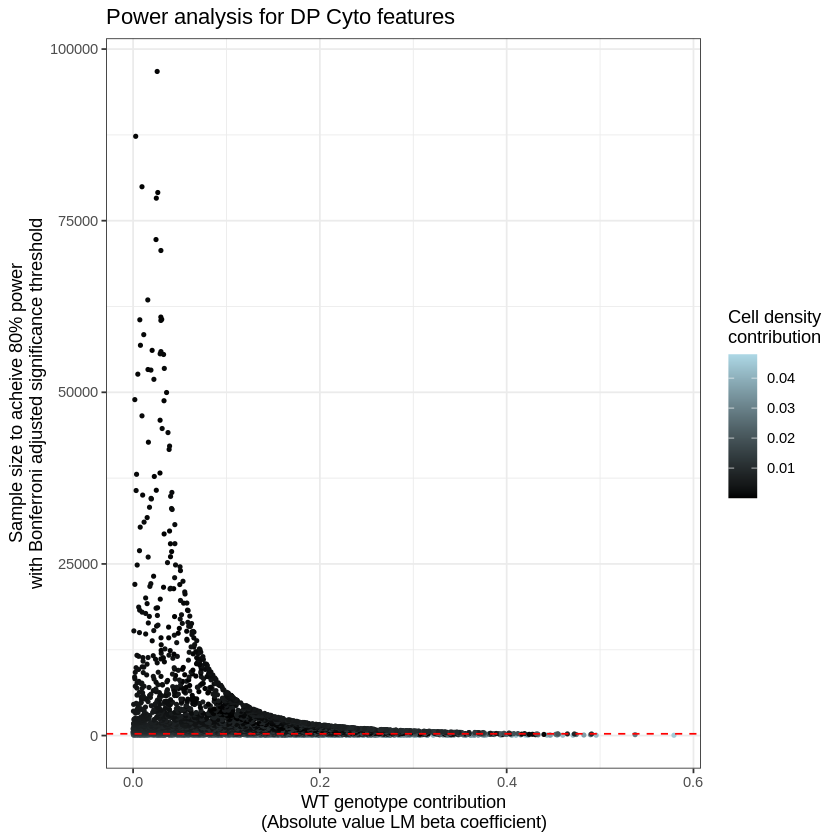

In [10]:
power_gg <- (
    ggplot(lm_data_df, aes(y = estimated_sample_size, x = abs(WT_coef)))
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for DP Cyto features")
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_gg

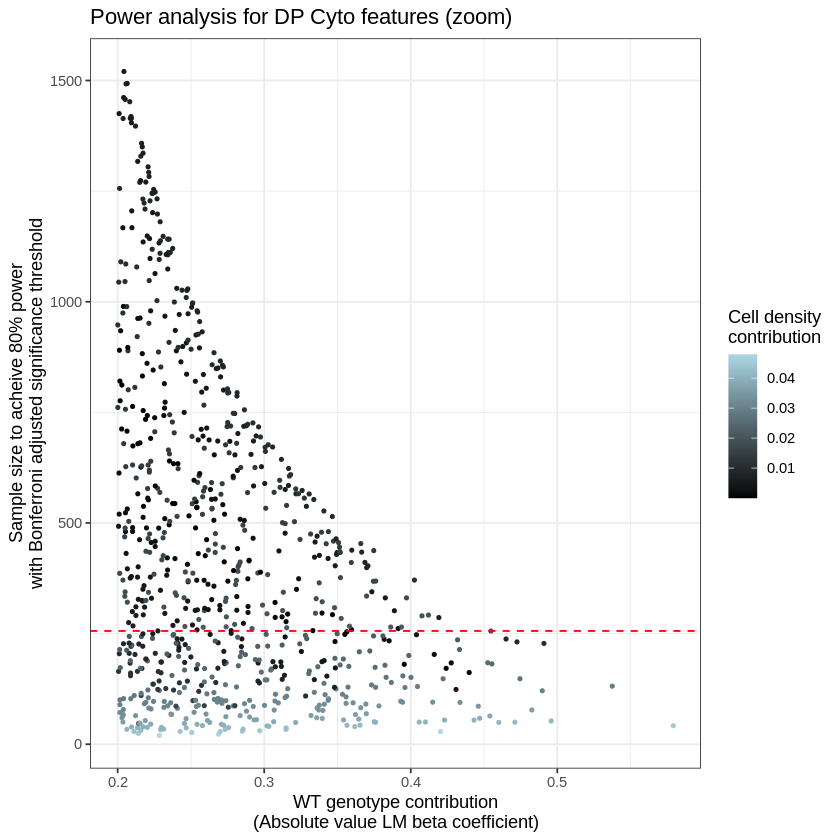

In [11]:
power_zoom_gg <- (
    ggplot(
        lm_data_df %>% dplyr::filter(abs(WT_coef) > 0.2),
        aes(y = estimated_sample_size, x = abs(WT_coef))
    )
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for DP Cyto features (zoom)")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_zoom_gg

In [12]:
full_power_gg <- power_gg + power_zoom_gg
ggsave(output_dp_power_figure, full_power_gg, dpi = 500, width = 13, height = 6)